<h1>Links to datasets</h1>

Link to dataset: https://www.kaggle.com/code/egenius/starter-cert-insider-threat-cfc11c55-1/input

Alternative dataset: https://www.kaggle.com/datasets/mrajaxnp/cert-insider-threat-detection-research/data?select=http.csv

<h1>Imported Libraries</h1>

In [1]:
# Basic Libraries
import pandas as pd
import re
import string
import numpy as np
import nltk
from scipy import stats
import warnings


# NLP Tools
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models and Metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

# Download required NLTK data (only need to do this once)
nltk.download('punkt')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OnilChibaya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OnilChibaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1>Preprocessing</h1>

<h4>Import Dataset</h4>

In [2]:
dataset = pd.read_csv('email.csv')
# dataset.head()

<h2>Pre-preprocessing</h2>

Split the 'datetime' column into 'date' and 'time' columns

In [3]:
# Split the 'datetime' column into 'date' and 'time' columns
split_df = dataset['date'].str.split(' ', expand=True)
dataset['date'] = split_df[0]
dataset['time'] = split_df[1].fillna('00:00:00')  # Fill missing time values with a default time if needed
# dataset.head()

Convert email addresses to the number of addresses in each row

In [4]:
# Convert email addresses to the number of addresses in each row
dataset['to'] = dataset['to'].str.count(';') + 1
# dataset.head()

Convert cc addresses to the number of addresses in each row

In [5]:
# Convert cc addresses to the number of addresses in each row
dataset['cc'] = dataset['cc'].apply(lambda x: x.count(';') + 1 if pd.notna(x) else 0)
# dataset.head()

Convert bcc addresses to the number of addresses in each row

In [6]:
# Convert bcc addresses to the number of addresses in each row
dataset['bcc'] = dataset['bcc'].apply(lambda x: x.count(';') + 1 if pd.notna(x) else 0)
# dataset.head()

Convert the text in 'from' to lowercase

In [7]:
# Convert the text in 'from' to lowercase
dataset['from'] = dataset['from'].str.lower()
# dataset.head()

Rearrange columns

In [8]:
# Rearrange columns
dataset = dataset[['id', 'pc', 'user', 'date', 'time', 'from', 'to', 'cc', 'bcc', 'size', 'attachments', 'content']]
dataset.head()

,id,pc,user,date,time,from,to,cc,bcc,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},PC-5758,LAP0338,01/02/2010,07:11:45,lynn.adena.pratt@dtaa.com,2,1,0,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},PC-6699,MOH0273,01/02/2010,07:12:16,moh68@optonline.net,1,0,0,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},PC-5758,LAP0338,01/02/2010,07:13:00,lynn_a_pratt@earthlink.net,1,0,0,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},PC-5758,LAP0338,01/02/2010,07:13:17,lynn_a_pratt@earthlink.net,1,0,0,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},PC-6699,MOH0273,01/02/2010,07:13:28,moh68@optonline.net,3,0,1,17319,0,this kmh october holliswood number advised unu...


<h1>Preprocessing</h1>

convert date and time to numerical data for the standardization and normalization process.

In [9]:
# Remove '/' from the 'date'
dataset['date'] = dataset['date'].str.replace('/', '')
# dataset.head()

Remove ':' from the 'time'

In [10]:
# Remove ':' from the 'time'
dataset['time'] = dataset['time'].str.replace(':', '')
# dataset.head()

Converting the PC- column to niumeric by removing the PC- string and keeping the PC value only.

In [11]:
# Remove the "PC-" prefix
dataset['pc'] = dataset['pc'].str.replace('PC-', '')
# dataset.head()

Rearrange columns

In [12]:
# Rearrange columns
dataset = dataset[['id', 'user', 'from', 'pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'content']]
# dataset.head()

Feature Engineering

In [13]:
# Character Count
dataset['char_count'] = dataset['content'].apply(len)

# Word Count
dataset['word_count'] = dataset['content'].apply(lambda x: len(x.split()))

# Average Word Length
dataset['avg_word_length'] = dataset['content'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)

# Counting the number of sentences
dataset['sentence_count'] = dataset['content'].apply(lambda x: len(sent_tokenize(x)))

In [14]:
# Rearrange columns
dataset = dataset[['id', 'user', 'from', 'pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'char_count', 'word_count', 'avg_word_length', 'sentence_count', 'content']]
# dataset.head()

<h5>Standardization</h5>

Before standardizing the data, we have to convert the pc, date and time varialbles to type int64

In [15]:
# Convert column 'pc', 'date' and time to int64
dataset['pc'] = dataset['pc'].astype('int64')

dataset['date'] = dataset['date'].astype('int64')

dataset['time'] = dataset['time'].astype('int64')
# dataset.head()

Identify and Standardize numeric columns

In [16]:
# Identify numeric columns
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns

# Standardize numeric columns
scaler = StandardScaler()
dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])
# dataset.head()

<h1>Identify numerical anomalies</h1>

We calculate the z-scores, identify whether there are anomalies or not with a threshold of 2. We then extract the anomaloes and separate the two datasets into on contaning anomalies and one without.

In [17]:
# Calculate Z-scores
z_scores = stats.zscore(dataset.select_dtypes(include=['float64', 'int64']))

# Get boolean DataFrame indicating the presence of anomalies (using a threshold of 2)
anomalies_bool_df = pd.DataFrame(z_scores, columns=dataset.select_dtypes(include=['float64', 'int64']).columns, index=dataset.index)
anomalies_bool_df = (anomalies_bool_df > 2) | (anomalies_bool_df < -2)

# Extract anomalies
anomalies = dataset[anomalies_bool_df.any(axis=1)]

# Drop anomalies from the original dataset
df_no_anomalies = dataset.drop(anomalies.index)

# Display the datasets
print("Normal Dataset:")
print(df_no_anomalies)
print("\nAnomalous Dataset:")
print(anomalies)

Normal Dataset:
                               id     user                             from  \
0        {R3I7-S4TX96FG-8219JWFF}  LAP0338        lynn.adena.pratt@dtaa.com   
1        {R0R9-E4GL59IK-2907OSWJ}  MOH0273              moh68@optonline.net   
2        {G2B2-A8XY58CP-2847ZJZL}  LAP0338       lynn_a_pratt@earthlink.net   
3        {A3A9-F4TH89AA-8318GFGK}  LAP0338       lynn_a_pratt@earthlink.net   
5        {X8T7-A6BT54FP-7241DLBV}  HVB0037        hollee_becker@hotmail.com   
...                           ...      ...                              ...   
2629876  {P4V8-L7RO47MY-3213UULA}  AMR0400   aurelia.martina.reese@dtaa.com   
2629877  {O1Z8-G3PF06XP-5478BCXH}  IAR0694        imani.aubrey.ray@dtaa.com   
2629879  {N1S7-E0NN19WN-8990TPMW}  IYB0918  illana.y.bradshaw@earthlink.net   
2629880  {E6T8-T3NA73UB-5296YCSP}  KMB0922           benson-keegan@juno.com   
2629881  {C8H6-E1SY12PC-3605SXAV}  IYB0918  illana.yvette.bradshaw@dtaa.com   

               pc      date      ti

Here we combine the two dataframes after adding the numeric_anomalies column. The column contains values, either 1 or 0 where 1 indicates that there are anomalies in the dataset and 0 indicates that there are no anomalies in the dataset.

In [18]:
df_no_anomalies['numeric_anomalies'] = 0
anomalies['numeric_anomalies'] = 1
# Combine dataframes vertically
dataset = pd.concat([df_no_anomalies, anomalies])

# Order by index
dataset = dataset.sort_index()
# dataset.head()

<h1>Text Pre-processing</h1>

Convert the text in 'content' to lowercase

In [19]:
# Convert the text in 'content' to lowercase
dataset['content'] = dataset['content'].str.lower()
# dataset.head()

Below is a function used to preprocess the email content in the 'content' column. We start by tokenizing the content of the email, removing stop words and then stemming the content using the python PorterStemmer() function.

In [20]:
def preprocess_email_content(email):
    # Tokenization
    tokens = word_tokenize(email)

    # Removal of stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return ' '.join(stemmed_tokens)

Apply preprocessing to the 'content' column

In [21]:
# Apply preprocessing to the 'content' column
dataset['content'] = dataset['content'].apply(preprocess_email_content)

<h1>Detect Sentiment Anomalies</h1>

Here we begin by performing sentiment analysis to get the polarity scores in our 'content' column. We then use this sentiment scores to detect anomalies using the IsolationForest model. We then display this data in the form of a Scatter Plot. (no anomalies dataset)

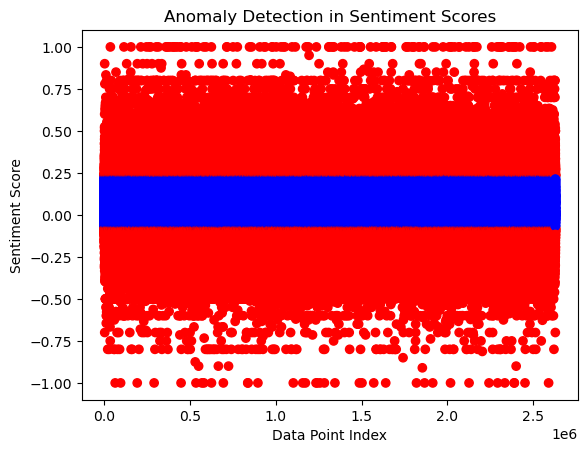

In [22]:
# Perform sentiment analysis and get polarity scores
df_no_anomalies['sentiment_score'] = df_no_anomalies['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Detect anomalies using Isolation Forest
clf = IsolationForest(contamination=0.2)
df_no_anomalies['sentiment_anomaly'] = clf.fit_predict(df_no_anomalies[['sentiment_score']])

# Create a color map based on the 'sentiment_anomaly' values
colors = df_no_anomalies['sentiment_anomaly'].apply(lambda x: 'red' if x == -1 else 'blue')

# Plot sentiment scores and anomalies
plt.scatter(df_no_anomalies.index, df_no_anomalies['sentiment_score'], c=colors)
plt.xlabel('Data Point Index')
plt.ylabel('Sentiment Score')
plt.title('Anomaly Detection in Sentiment Scores')
plt.show()

Here we begin by performing sentiment analysis to get the polarity scores in our 'content' column. We then use this sentiment scores to detect anomalies using the IsolationForest model. We then display this data in the form of a Scatter Plot. (anomalies dataset)

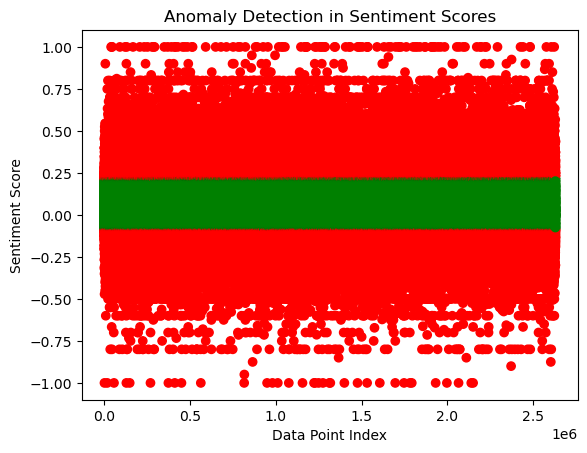

In [23]:
# Perform sentiment analysis and get polarity scores
anomalies['sentiment_score'] = anomalies['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Detect anomalies using Isolation Forest
clf = IsolationForest(contamination=0.2)
anomalies['sentiment_anomaly'] = clf.fit_predict(anomalies[['sentiment_score']])

# Create a color map based on the 'sentiment_anomaly' values
colors = anomalies['sentiment_anomaly'].apply(lambda x: 'red' if x == -1 else 'green')

# Plot sentiment scores and anomalies
plt.scatter(anomalies.index, anomalies['sentiment_score'], c=colors)
plt.xlabel('Data Point Index')
plt.ylabel('Sentiment Score')
plt.title('Anomaly Detection in Sentiment Scores')
plt.show()

Combine the dataframes vertically and order them by their original index numbers.

In [24]:
# Combine dataframes vertically
dataset = pd.concat([df_no_anomalies, anomalies])
# Order by index
dataset = dataset.sort_index()
# dataset.head()

<h1>Feature Engineering</h1>

Replace all occurrences of 1 with 0 in 'sentiment_anomaly' and then all occurrences of -1 with 1 in the same column.

In [25]:
# Replace all occurrences of 1 with 0 in 'sentiment_anomaly' and then all occurrences of -1 with 1 in the same column.
dataset['sentiment_anomaly'] = dataset['sentiment_anomaly'].replace(1, 0)
dataset['sentiment_anomaly'] = dataset['sentiment_anomaly'].replace(-1, 1)
# dataset.head()

Creating the 'target' value.

In [26]:
# Add a new column 'target' which is the sum of 'numeric_anomalies' and 'sentiment_anomaly'
dataset['target'] = dataset['numeric_anomalies'] + dataset['sentiment_anomaly']
dataset.head()

,id,user,from,pc,date,time,to,cc,bcc,size,attachments,char_count,word_count,avg_word_length,sentence_count,content,numeric_anomalies,sentiment_score,sentiment_anomaly,target
0,{R3I7-S4TX96FG-8219JWFF},LAP0338,lynn.adena.pratt@dtaa.com,0.225155,-1.350869,-1.776521,0.391517,0.657642,-0.422412,-0.416497,-0.38441,0.799004,1.347242,-1.226924,0.0,middle f2 systems 4 july techniques powerful d...,0,0.130000,0,0
1,{R0R9-E4GL59IK-2907OSWJ},MOH0273,moh68@optonline.net,0.544371,-1.350869,-1.774182,-0.695123,-0.687330,-0.422412,-0.005035,-0.38441,-0.629780,-0.649797,-0.042513,0.0,the breaking called allied reservations former...,0,0.150000,0,0
2,{G2B2-A8XY58CP-2847ZJZL},LAP0338,lynn_a_pratt@earthlink.net,0.225155,-1.350869,-1.771414,-0.695123,-0.687330,-0.422412,-0.121309,-0.38441,-1.000205,-0.949353,-0.387054,0.0,slowly this uncinus winter beneath addition ex...,0,-0.191667,1,1
3,{A3A9-F4TH89AA-8318GFGK},LAP0338,lynn_a_pratt@earthlink.net,0.225155,-1.350869,-1.770854,-0.695123,-0.687330,-0.422412,-0.809047,-0.38441,0.058153,-0.050686,0.347231,0.0,400 other difficult land cirrocumulus powered ...,0,0.021875,0,0
4,{E8B7-C8FZ88UF-2946RUQQ},MOH0273,moh68@optonline.net,0.544371,-1.350869,-1.770491,1.478157,-0.687330,2.101201,-1.268139,-0.38441,0.124301,0.049166,0.247887,0.0,this kmh october holliswood number advised unu...,1,0.160494,0,1


Identifying and Standardizing new numeric columns.

In [27]:
# Identify numeric columns
numeric_columns = ['numeric_anomalies', 'sentiment_score', 'sentiment_anomaly']

# Standardize numeric columns
scaler = StandardScaler()
dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])
# dataset.head()

Rearrange columns

In [28]:
# Rearrange columns
dataset = dataset[['id', 'user', 'from', 'pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'char_count', 'word_count', 'avg_word_length', 'sentence_count', 'sentiment_score', 'numeric_anomalies', 'sentiment_anomaly','content', 'target']]
dataset.head()

,id,user,from,pc,date,time,to,cc,bcc,size,attachments,char_count,word_count,avg_word_length,sentence_count,sentiment_score,numeric_anomalies,sentiment_anomaly,content,target
0,{R3I7-S4TX96FG-8219JWFF},LAP0338,lynn.adena.pratt@dtaa.com,0.225155,-1.350869,-1.776521,0.391517,0.657642,-0.422412,-0.416497,-0.38441,0.799004,1.347242,-1.226924,0.0,0.555100,-0.838153,-0.499568,middle f2 systems 4 july techniques powerful d...,0
1,{R0R9-E4GL59IK-2907OSWJ},MOH0273,moh68@optonline.net,0.544371,-1.350869,-1.774182,-0.695123,-0.687330,-0.422412,-0.005035,-0.38441,-0.629780,-0.649797,-0.042513,0.0,0.714510,-0.838153,-0.499568,the breaking called allied reservations former...,0
2,{G2B2-A8XY58CP-2847ZJZL},LAP0338,lynn_a_pratt@earthlink.net,0.225155,-1.350869,-1.771414,-0.695123,-0.687330,-0.422412,-0.121309,-0.38441,-1.000205,-0.949353,-0.387054,0.0,-2.008749,-0.838153,2.001731,slowly this uncinus winter beneath addition ex...,1
3,{A3A9-F4TH89AA-8318GFGK},LAP0338,lynn_a_pratt@earthlink.net,0.225155,-1.350869,-1.770854,-0.695123,-0.687330,-0.422412,-0.809047,-0.38441,0.058153,-0.050686,0.347231,0.0,-0.306712,-0.838153,-0.499568,400 other difficult land cirrocumulus powered ...,0
4,{E8B7-C8FZ88UF-2946RUQQ},MOH0273,moh68@optonline.net,0.544371,-1.350869,-1.770491,1.478157,-0.687330,2.101201,-1.268139,-0.38441,0.124301,0.049166,0.247887,0.0,0.798151,1.193100,-0.499568,this kmh october holliswood number advised unu...,1


<h1>Feature Selection</h1>

Below is a heatmap of the feature correlation. The heatmap below is used to visualize which of the feature in our dataset influence the target variable the most.

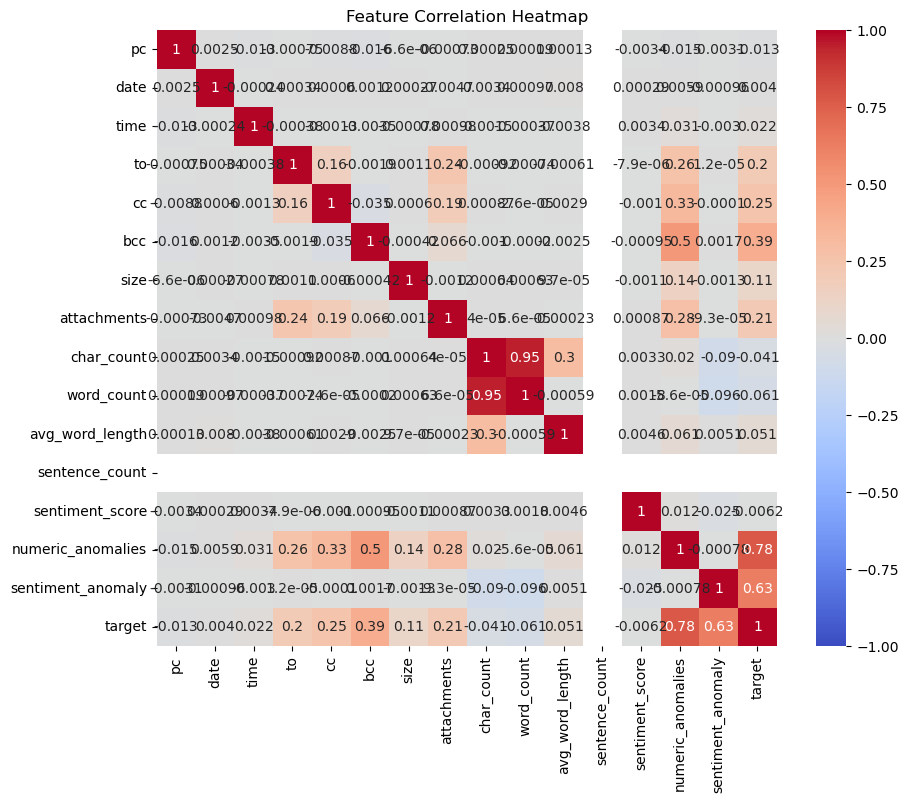

In [29]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Display the heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

Below are some Feature Selection methods.

- Filter Method: We identify features that are highly correlated (here I used a threshold of 0.8) and remove them since they might carry redundant information.

- Wrapper Method: Using RFE, we wrap around a model (in this case, LinearRegression) to rank features based on their importance in predicting the target. Here, we're selecting 5 top features.

- Embedded Method: We utilize a RandomForest model to compute feature importances and select features that have an importance score above the mean.

Each method will likely produce a different subset of features. The best set often depends on the problem and the model you're planning to use. Testing the performance of your machine learning model with each subset will provide more insights into which features to finally select.

In [30]:
dataset = dataset[['pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'char_count', 'word_count', 'avg_word_length', 'sentence_count', 'sentiment_score', 'numeric_anomalies', 'sentiment_anomaly', 'target']]
X = dataset.drop('target', axis=1)  # Features
y = dataset['target']  # Target variable (0 for normal, 1 for insider threat)
feature_names = X.columns  # This is the corrected line

# 1. Filter Method
# Removing features with high correlation
correlation_matrix = pd.DataFrame(X, columns=feature_names).corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
features_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
X_filtered = pd.DataFrame(X, columns=feature_names).drop(features_to_drop, axis=1)

# 2. Wrapper Method
# Recursive Feature Elimination
estimator = LinearRegression()
selector = RFE(estimator=estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
selected_features_wrapper = np.array(feature_names)[selector.support_]

# 3. Embedded Method
# Feature importances from Random Forest
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)
importances = model.feature_importances_
selected_features_embedded = np.array(feature_names)[importances > np.mean(importances)]

print("Features selected by Filter method:", list(X_filtered.columns))
print("Features selected by Wrapper method:", list(selected_features_wrapper))
print("Features selected by Embedded method:", list(selected_features_embedded))

KeyboardInterrupt: 

New dataset of selected Features

In [ ]:
dataset = dataset[['cc', 'bcc', 'size', 'numeric_anomalies', 'sentiment_anomaly', 'target']]
X = dataset.drop('target', axis=1)  # Features
y = dataset['target']  # Target variable (0 for normal, 1 for insider threat)

Below is the updated heatmap of features in correlation to the target value.

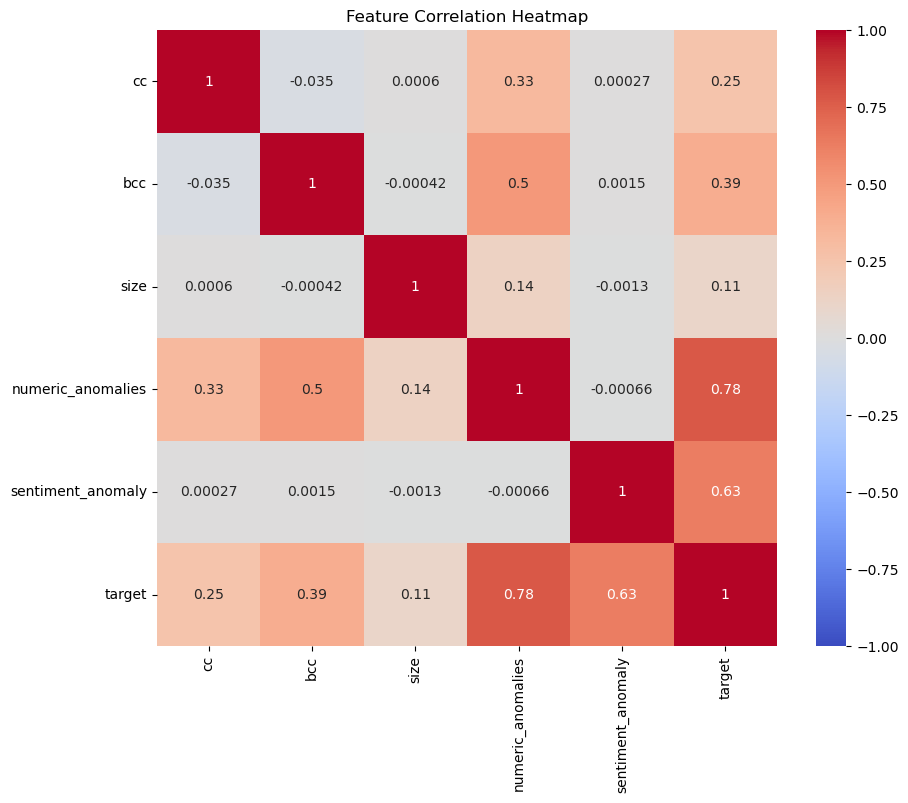

In [ ]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Display the heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

<h1>Model training and testing</h1>

Random Forest

In [ ]:
# Split the data into training and testing sets
X = dataset.drop('target', axis=1)  # Features
y = dataset['target']  # Target variable (0 for normal, 1 for insider threat)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create and train a Random Forest classifier
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print a classification report for more detailed evaluation
print(classification_report(y_test, y_pred))


Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    247502
           1       1.00      1.00      1.00    235494
           2       1.00      1.00      1.00     43000

    accuracy                           1.00    525996
   macro avg       1.00      1.00      1.00    525996
weighted avg       1.00      1.00      1.00    525996



SVM Classifier

In [ ]:
# Create an SVM classifier with class weights
svm_classifier = SVC(class_weight='balanced', kernel='linear', C=1.0, random_state=42)

# Train the model
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)

# Use 'weighted' average for recall and F1-score
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("SVM Accuracy:", accuracy)
print("SVM Weighted Recall:", recall)
print("SVM Weighted F1-score:", f1)

SVM Accuracy: 1.0
SVM Weighted Recall: 1.0
SVM Weighted F1-score: 1.0


Logistic Regression

In [ ]:
# Create a Logistic Regression classifier with class weights
logistic_classifier = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model
logistic_classifier.fit(X_train, y_train)

# Make predictions
y_pred = logistic_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass classification
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass classification

# Print the evaluation metrics
print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Weighted Recall:", recall)
print("Logistic Regression Weighted F1-score:", f1)


Logistic Regression Accuracy: 1.0
Logistic Regression Weighted Recall: 1.0
Logistic Regression Weighted F1-score: 1.0


Decision Tree

In [ ]:
# Create a Decision Tree classifier with class weights
tree_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Train the model
tree_classifier.fit(X_train, y_train)

# Make predictions
y_pred = tree_classifier.predict(X_test)

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass classification
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass classification

# Print the evaluation metrics
print("Decision Tree Accuracy:", accuracy)
print("Decision Tree Weighted Recall:", recall)
print("Decision Tree Weighted F1-score:", f1)


Decision Tree Accuracy: 1.0
Decision Tree Weighted Recall: 1.0
Decision Tree Weighted F1-score: 1.0


Ensemble model made up of a Random Forest Classifier, SVM Classifier, Logistic Regression Model and Decision Tree Classifier.

In [ ]:
# Create individual classifiers
random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
svc_classifier = SVC(class_weight='balanced', kernel='linear', C=1.0, probability=True, random_state=42)
logistic_classifier = LogisticRegression(class_weight='balanced', random_state=42)
tree_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Create an ensemble classifier using voting
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('svc', svc_classifier),
    ('logistic', logistic_classifier),
    ('tree', tree_classifier)
], voting='soft')  # Use 'soft' voting for probability-based voting

# Train the ensemble model
ensemble_classifier.fit(X_train, y_train)

# Make predictions
y_pred = ensemble_classifier.predict(X_test)

# Evaluate the ensemble model (you can calculate various metrics)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Ensemble Accuracy:", accuracy)
print("Ensemble Weighted Recall:", recall)
print("Ensemble Weighted F1-score:", f1)


Ensemble Accuracy: 1.0
Ensemble Weighted Recall: 1.0
Ensemble Weighted F1-score: 1.0


<h1>Cross validation</h1>

K-fold cross-validation

We then performed hyperparemeter tuning and 10-fold cross validation to cater for the overfitting issue through an ensemble model of three models, the code to do so is presented below:

In [110]:
# Define the individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svc_model = SVC(probability=True, random_state=42)
logreg_model = LogisticRegression(random_state=42)

# Create an ensemble of the models using majority class voting
ensemble_model = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('svc', svc_model),
    ('logistic_regression', logreg_model)
], voting='soft')

param_grid_ensemble = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]]
}

# Apply 10-fold cross-validation
grid_search_ensemble = GridSearchCV(ensemble_model, param_grid_ensemble, cv=10)
grid_search_ensemble.fit(X, y)

best_ensemble = grid_search_ensemble.best_estimator_

# Evaluating best ensemble model using 10-fold CV
scores = cross_val_score(best_ensemble, X, y, cv=10)
print(f"Accuracy for each fold: {scores}")
print(f"Average accuracy: {scores.mean()}")

Conducting a study on predicting insider threat detection on an email dataset using sentiment analysis involves several steps. Here's a comprehensive breakdown:

1. **Define the Objective**:
   - Clearly state the purpose of the study. For instance, "To predict potential insider threats based on the sentiment expressed in email communications."

2. **Data Collection**:
   - **Source the Dataset**: Obtain a dataset of email communications. Ensure that you have the necessary permissions and that all data is anonymized to protect privacy.
   - **Data Cleaning**: Remove any irrelevant data, correct inconsistencies, and handle missing values.

3. **Pre-processing**:
   - **Tokenization**: Break down the email text into individual words or tokens.
   - **Stopword Removal**: Remove common words (e.g., "and", "the") that don't contribute to sentiment.
   - **Stemming/Lemmatization**: Reduce words to their base or root form (e.g., "running" to "run").

4. **Feature Extraction**:
   - **Sentiment Analysis Tools**: Use tools or libraries like TextBlob, VADER, or custom models to extract sentiment scores from the email text.
   - **Other Features**: Consider extracting other features like email length, time sent, frequency of communication, etc.

5. **Data Labeling**:
   - If the dataset is not labeled, you might need to manually label a subset of the data or use unsupervised methods to identify potential threats.

6. **Model Selection**:
   - Choose appropriate machine learning models for prediction. Common choices for sentiment analysis include Naive Bayes, Support Vector Machines, and Deep Learning models like LSTM or BERT.

7. **Training & Validation**:
   - **Split the Data**: Divide the dataset into training, validation, and test sets.
   - **Train the Model**: Use the training set to train the model.
   - **Validation**: Fine-tune the model using the validation set to avoid overfitting.

8. **Evaluation**:
   - **Test the Model**: Use the test set to evaluate the model's performance.
   - **Metrics**: Use appropriate metrics like accuracy, precision, recall, F1-score, and ROC curve to assess the model's effectiveness in predicting insider threats.

9. **Interpretation**:
   - Analyze the results to understand which features are most indicative of insider threats. This can provide insights into the nature of the threats and potential mitigation strategies.

10. **Deployment**:
   - If the model performs well, consider deploying it in a real-world environment to monitor email communications and flag potential threats.

11. **Feedback Loop**:
   - Continuously monitor the model's performance in the real world. Collect feedback and retrain the model as needed to adapt to changing patterns of communication and threats.

12. **Ethical Considerations**:
   - Ensure that the study respects privacy laws and regulations. Anonymize personal data and obtain necessary permissions.
   - Be transparent about the study's objectives and methods, and provide avenues for individuals to opt-out if desired.

13. **Documentation & Reporting**:
   - Document the entire process, from data collection to deployment. This ensures reproducibility and transparency.
   - Report findings, insights, and recommendations based on the study.

Remember, predicting insider threats is a sensitive task, and false positives can have serious implications. It's crucial to approach the study with caution, ensuring accuracy, fairness, and ethical considerations are at the forefront.